In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

In [2]:
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")

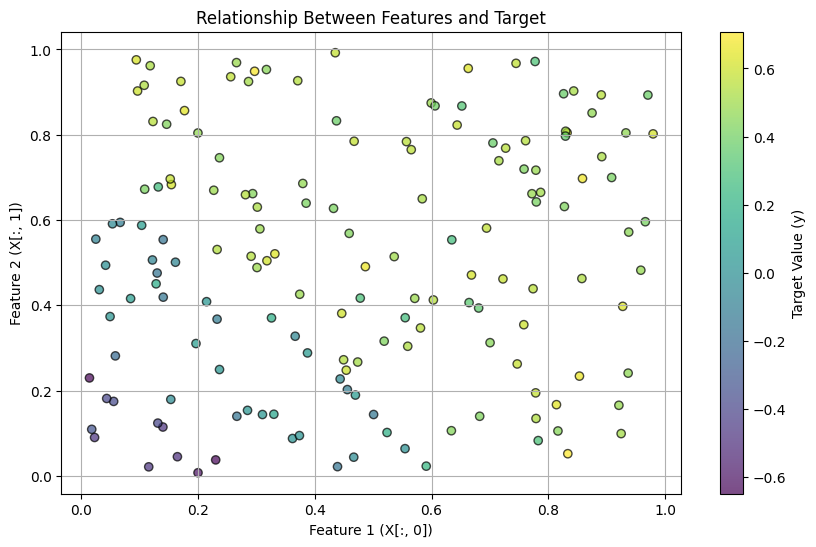

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [5]:
n_runs = 10
n_skip = 100
n_post = 200
n_trees = 100
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees})
    sto_pred_all_test = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train), axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_f(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)


Iterations: 100%|██████████| 300/300 [00:14<00:00, 20.18it/s]
INFO:2025-05-29 20:16:07,556:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-29 20:16:07,559:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.38 A_prune=0.50 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.40 A_prune=0.47
Iteration 300/300 P_grow=0.58 P_prune=0.42 A_grow=0.36 A_prune=0.40


Iterations: 100%|██████████| 300/300 [00:08<00:00, 36.89it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.33 A_prune=0.26 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.28 A_prune=0.35
Iteration 300/300 P_grow=0.58 P_prune=0.42 A_grow=0.26 A_prune=0.43


Iterations: 100%|██████████| 300/300 [00:08<00:00, 33.74it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.40 A_prune=0.33 (burnin)
Iteration 200/300 P_grow=0.59 P_prune=0.41 A_grow=0.37 A_prune=0.39
Iteration 300/300 P_grow=0.59 P_prune=0.41 A_grow=0.36 A_prune=0.44


Iterations: 100%|██████████| 300/300 [00:08<00:00, 35.01it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.38 A_prune=0.38 (burnin)
Iteration 200/300 P_grow=0.58 P_prune=0.42 A_grow=0.36 A_prune=0.50
Iteration 300/300 P_grow=0.60 P_prune=0.40 A_grow=0.33 A_prune=0.47


Iterations: 100%|██████████| 300/300 [00:08<00:00, 34.08it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.39 A_prune=0.39 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.36 A_prune=0.27
Iteration 300/300 P_grow=0.59 P_prune=0.41 A_grow=0.37 A_prune=0.49


Iterations: 100%|██████████| 300/300 [00:08<00:00, 34.11it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.34 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.32 A_prune=0.42
Iteration 300/300 P_grow=0.60 P_prune=0.40 A_grow=0.33 A_prune=0.47


Iterations: 100%|██████████| 300/300 [00:08<00:00, 36.80it/s]


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.40 A_prune=0.38 (burnin)
Iteration 200/300 P_grow=0.58 P_prune=0.42 A_grow=0.36 A_prune=0.43
Iteration 300/300 P_grow=0.58 P_prune=0.42 A_grow=0.34 A_prune=0.45


Iterations: 100%|██████████| 300/300 [00:09<00:00, 32.94it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.34 A_prune=0.32 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.39 A_prune=0.43
Iteration 300/300 P_grow=0.59 P_prune=0.41 A_grow=0.34 A_prune=0.54


Iterations: 100%|██████████| 300/300 [00:08<00:00, 34.77it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.30 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.58 P_prune=0.42 A_grow=0.33 A_prune=0.33
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.30 A_prune=0.33


Iterations: 100%|██████████| 300/300 [00:08<00:00, 34.10it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.30 A_prune=0.40 (burnin)
Iteration 200/300 P_grow=0.59 P_prune=0.41 A_grow=0.44 A_prune=0.39
Iteration 300/300 P_grow=0.55 P_prune=0.45 A_grow=0.31 A_prune=0.38


In [6]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart    0.022565
btz     0.023345
sto     0.024417
rf      0.023791
xgb     0.029138
lr      0.055284
dtype: float64
Train MSE Mean:
bart    0.010600
btz     0.011614
sto     0.009532
rf      0.003253
xgb     0.000003
lr      0.044897
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    0.303692
btz     0.295941
sto     0.317595
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart    0.6475
btz     0.6550
sto     0.6775
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    9.290539
btz     1.465900
sto     0.191939
rf      0.105075
xgb     0.037596
lr      0.001152
dtype: float64


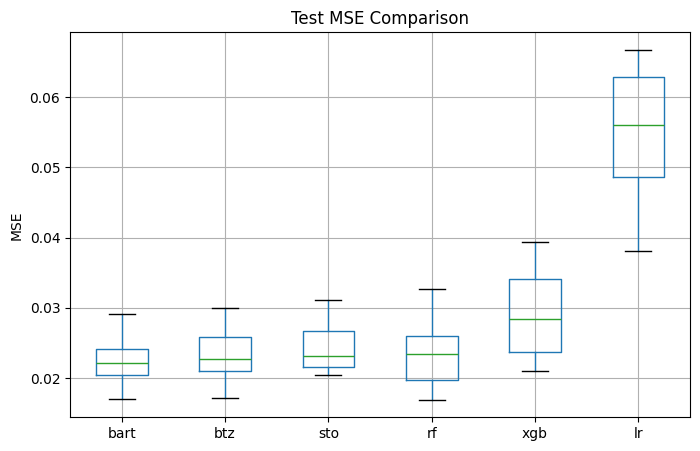

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

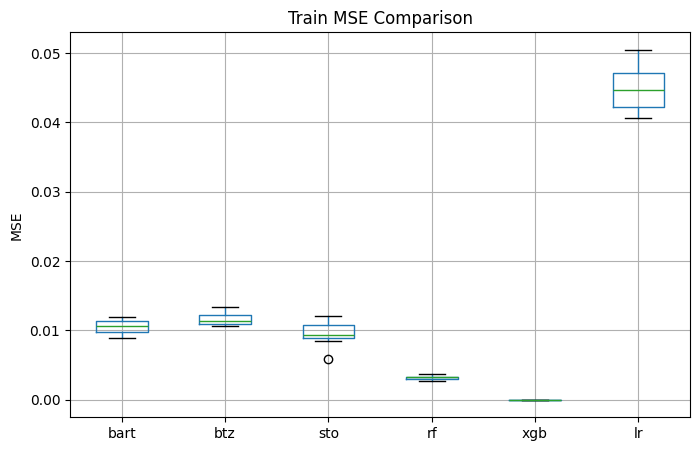

In [8]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

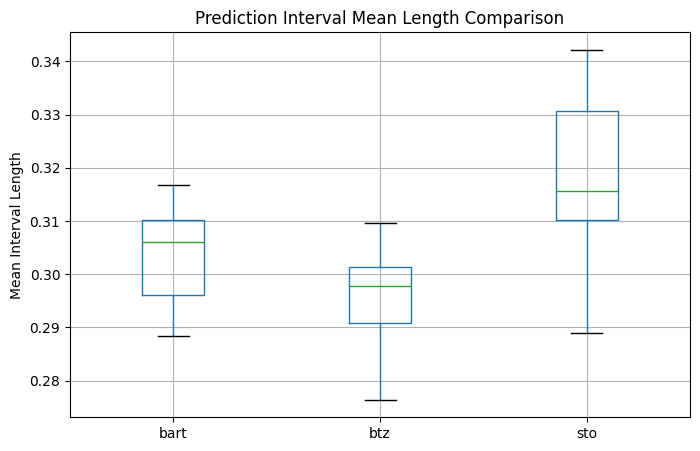

In [9]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

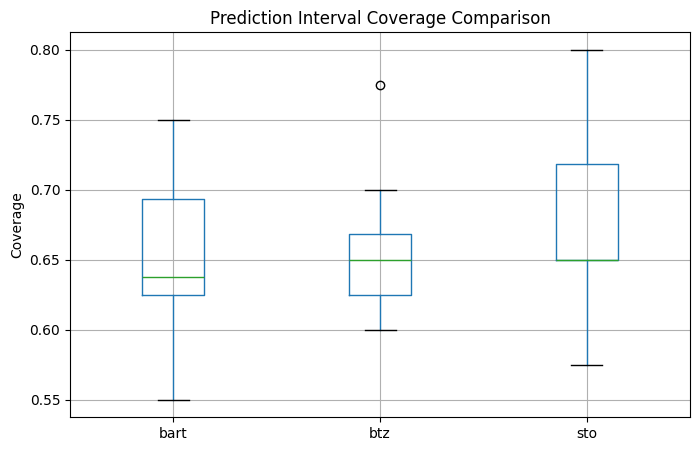

In [10]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

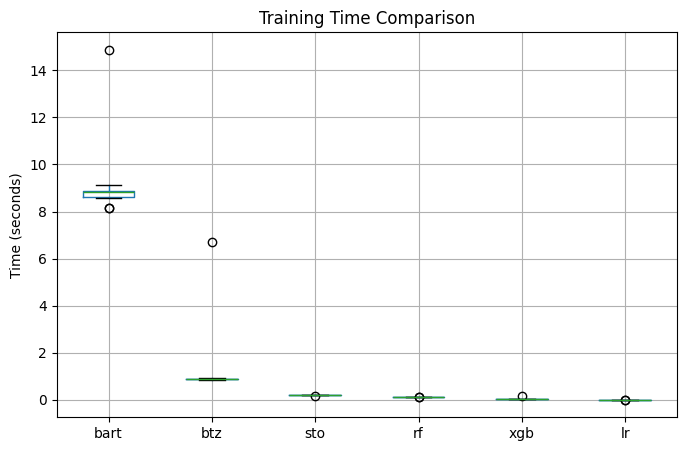

In [11]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()